In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from torch.amp import autocast, GradScaler
from efficientnet_pytorch import EfficientNet
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder



In [2]:
# Check for GPU availability
if torch.cuda.is_available():
    print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ GPU not available. Using CPU.")

# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 4
EPOCHS = 50
NUM_CLASSES = 4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


✅ GPU available: NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
# Define individual models
class BaseModel(nn.Module):
    def __init__(self, arch, pretrained=True, num_classes=NUM_CLASSES):
        super(BaseModel, self).__init__()
        self.arch = arch

        if arch == 'efficientnet_b0':
            self.model = EfficientNet.from_pretrained('efficientnet-b0')
            num_features = self.model._fc.in_features
            self.model._fc = nn.Linear(num_features, num_classes)

        elif arch == 'resnet18':
            self.model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
            num_features = self.model.fc.in_features
            self.model.fc = nn.Linear(num_features, num_classes)

        elif arch == 'mobilenet_v3':
            self.model = torchvision.models.mobilenet_v3_large(weights=torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
            num_features = self.model.classifier[0].in_features
            self.model.classifier = nn.Sequential(nn.Linear(num_features, num_classes))

        else:
            raise ValueError(f"Unsupported architecture: {arch}")

        # Freeze all base model layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze classifier head
        if arch == 'resnet18':
            for param in self.model.fc.parameters():
                param.requires_grad = True
        elif arch == 'efficientnet_b0':
            for param in self.model._fc.parameters():
                param.requires_grad = True
        elif arch == 'mobilenet_v3':
            for param in self.model.classifier[0].parameters():
                param.requires_grad = True

    def forward(self, x):
        return self.model(x)


In [4]:
# Ensemble Model that loads pre-trained individual models
class EnsembleModel(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(EnsembleModel, self).__init__()

        self.resnet = BaseModel('resnet18').to(DEVICE)
        self.resnet.load_state_dict(torch.load("resnet18_best.pth", map_location=DEVICE))

        self.efficient = BaseModel('efficientnet_b0').to(DEVICE)
        self.efficient.load_state_dict(torch.load("efficientnet_b0_best.pth", map_location=DEVICE))

        self.mobilenet = BaseModel('mobilenet_v3').to(DEVICE)
        self.mobilenet.load_state_dict(torch.load("mobilenet_v3_best.pth", map_location=DEVICE))

        # Freeze all models
        self.models = nn.ModuleList([self.resnet, self.efficient, self.mobilenet])
        for model in self.models:
            model.eval()
            for param in model.parameters():
                param.requires_grad = False

    def forward(self, x):
        outputs = []
        for model in self.models:
            with autocast('cuda'):
                output = model(x)
                outputs.append(torch.softmax(output, dim=1))

        # Average softmax probabilities (can use weighted avg here too)
        avg_output = torch.stack(outputs).mean(dim=0)
        return avg_output


In [5]:
# Split full dataset into train/val/test
def get_data_loaders_from_full_dir(data_dir, train_ratio=0.7, val_ratio=0.15):
    transform_train = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    full_dataset = datasets.ImageFolder(data_dir, transform=transform_train)

    total_size = len(full_dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

    # Apply test transform to val and test sets
    val_set.dataset.transform = transform_test
    test_set.dataset.transform = transform_test

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader, full_dataset.classes


In [6]:
train_loader, val_loader, test_loader, class_names = get_data_loaders_from_full_dir(r"C:\Users\joane\OneDrive\Desktop\Sem 7\Brain Tummor\Data")


In [7]:
def train_model(model, train_loader, val_loader, save_path):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)
    scaler = GradScaler('cuda')

    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(EPOCHS):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            with autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation loop
        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                with autocast('cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"[{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")

        scheduler.step(val_loss)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved best model with Val Acc: {val_acc:.2f}%")

    return history


In [15]:
model = BaseModel("resnet18").to(DEVICE)
train_model(model, train_loader, val_loader, "resnet18_best.pth")


c:\Users\joane\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[1/50] Train Loss: 0.9078 | Acc: 62.72% | Val Loss: 0.7172 | Acc: 73.14%
✅ Saved best model with Val Acc: 73.14%
[2/50] Train Loss: 0.8090 | Acc: 68.04% | Val Loss: 0.6275 | Acc: 77.91%
✅ Saved best model with Val Acc: 77.91%
[3/50] Train Loss: 0.7960 | Acc: 68.87% | Val Loss: 0.6216 | Acc: 77.32%
[4/50] Train Loss: 0.7892 | Acc: 69.06% | Val Loss: 0.6396 | Acc: 77.51%
[5/50] Train Loss: 0.7787 | Acc: 69.62% | Val Loss: 0.5880 | Acc: 79.08%
✅ Saved best model with Val Acc: 79.08%
[6/50] Train Loss: 0.7844 | Acc: 69.73% | Val Loss: 0.5941 | Acc: 79.45%
✅ Saved best model with Val Acc: 79.45%
[7/50] Train Loss: 0.7724 | Acc: 69.79% | Val Loss: 0.5922 | Acc: 78.40%
[8/50] Train Loss: 0.7642 | Acc: 70.18% | Val Loss: 0.5417 | Acc: 80.40%
✅ Saved best model with Val Acc: 80.40%
[9/50] Train Loss: 0.7756 | Acc: 70.16% | Val Loss: 0.5568 | Acc: 80.55%
✅ Saved best model with Val Acc: 80.55%
[10/50] Train Loss: 0.7758 | Acc: 70.20% | Val Loss: 0.8391 | Acc: 70.09%
[11/50] Train Loss: 0.7542 | 

{'train_loss': [0.9078438281384364,
  0.808950928374516,
  0.7959631885414918,
  0.7892470520403213,
  0.7786850310820814,
  0.7844272733614686,
  0.7723625200799861,
  0.7641738780940895,
  0.7755926954787103,
  0.775759811966142,
  0.7541844612166714,
  0.7255135608432854,
  0.719973739300433,
  0.7005372768321516,
  0.7064835471384701,
  0.6966659612825984,
  0.6932782396819515,
  0.6820820240304365,
  0.673552702967988,
  0.6761551718268078,
  0.686342621113611,
  0.6738462289247732,
  0.6710757709039789,
  0.6533102417821907,
  0.6752537029606039,
  0.6611421034388262,
  0.6601587859552767,
  0.6639702603272012,
  0.6581822328098588,
  0.6700027485557575,
  0.669549885931978,
  0.6735323614254496,
  0.6680149073466254,
  0.6594936197268564,
  0.6690155091242962,
  0.6711542328209227,
  0.675378837797279,
  0.665158420400446,
  0.6633904276314053,
  0.6647302912213763,
  0.6758786046093258,
  0.6544306433801126,
  0.6692843855825917,
  0.6701361308492585,
  0.6622983537184164,
  0.

In [11]:
model = BaseModel("efficientnet_b0").to(DEVICE)
train_model(model, train_loader, val_loader, "efficientnet_b0_best.pth")


Loaded pretrained weights for efficientnet-b0
[1/50] Train Loss: 0.8157 | Acc: 66.99% | Val Loss: 0.6241 | Acc: 77.29%
✅ Saved best model with Val Acc: 77.29%
[2/50] Train Loss: 0.7169 | Acc: 71.76% | Val Loss: 0.5903 | Acc: 78.65%
✅ Saved best model with Val Acc: 78.65%
[3/50] Train Loss: 0.7151 | Acc: 71.92% | Val Loss: 0.6077 | Acc: 77.85%
[4/50] Train Loss: 0.7034 | Acc: 72.86% | Val Loss: 0.5528 | Acc: 78.71%
✅ Saved best model with Val Acc: 78.71%
[5/50] Train Loss: 0.7074 | Acc: 72.35% | Val Loss: 0.5628 | Acc: 79.35%
✅ Saved best model with Val Acc: 79.35%
[6/50] Train Loss: 0.6883 | Acc: 72.91% | Val Loss: 0.5868 | Acc: 78.03%
[7/50] Train Loss: 0.7068 | Acc: 72.51% | Val Loss: 0.5870 | Acc: 78.03%
[8/50] Train Loss: 0.6857 | Acc: 73.28% | Val Loss: 0.5486 | Acc: 79.88%
✅ Saved best model with Val Acc: 79.88%
[9/50] Train Loss: 0.6713 | Acc: 73.77% | Val Loss: 0.5445 | Acc: 79.42%
[10/50] Train Loss: 0.6752 | Acc: 73.54% | Val Loss: 0.5286 | Acc: 80.40%
✅ Saved best model with

{'train_loss': [0.8157441438800139,
  0.716929883039818,
  0.715084491596667,
  0.7033962208081322,
  0.7074304805042685,
  0.6883499159242181,
  0.7067500887619861,
  0.6856725576006891,
  0.6713288001168098,
  0.6751958017546615,
  0.6725726628284671,
  0.6809158914484577,
  0.6757667644605956,
  0.6620093348816395,
  0.6513364819543142,
  0.6512758671577392,
  0.6472915747754655,
  0.6534799360094364,
  0.6613157613278063,
  0.6424186904559875,
  0.6469353476709657,
  0.6455234590963986,
  0.6404159706907979,
  0.6528899492074719,
  0.6358141233997737,
  0.6509101162351533,
  0.6386839777521932,
  0.6388135472420114,
  0.6480604965360568,
  0.6447536586505141,
  0.6521086666252756,
  0.6423991653462245,
  0.6327415406861093,
  0.6338637510327843,
  0.6413896120446293,
  0.6407949866168643,
  0.6398472070473968,
  0.6496533619329793,
  0.6412677410140442,
  0.6456677636699817,
  0.6389454058534767,
  0.6373164903558153,
  0.645045575886894,
  0.6448241333250568,
  0.6498068711105828,

In [8]:
model = BaseModel("mobilenet_v3").to(DEVICE)
train_model(model, train_loader, val_loader, "mobilenet_v3_best.pth")


c:\Users\joane\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[1/50] Train Loss: 0.8175 | Acc: 67.11% | Val Loss: 0.5181 | Acc: 80.95%
✅ Saved best model with Val Acc: 80.95%
[2/50] Train Loss: 0.7021 | Acc: 72.48% | Val Loss: 0.5565 | Acc: 79.60%
[3/50] Train Loss: 0.6709 | Acc: 74.21% | Val Loss: 0.4807 | Acc: 81.97%
✅ Saved best model with Val Acc: 81.97%
[4/50] Train Loss: 0.6443 | Acc: 74.90% | Val Loss: 0.5130 | Acc: 81.20%
[5/50] Train Loss: 0.6409 | Acc: 75.10% | Val Loss: 0.5063 | Acc: 81.08%
[6/50] Train Loss: 0.6300 | Acc: 75.47% | Val Loss: 0.4620 | Acc: 82.98%
✅ Saved best model with Val Acc: 82.98%
[7/50] Train Loss: 0.6214 | Acc: 75.71% | Val Loss: 0.5172 | Acc: 81.26%
[8/50] Train Loss: 0.6147 | Acc: 76.36% | Val Loss: 0.4873 | Acc: 82.28%
[9/50] Train Loss: 0.5994 | Acc: 77.16% | Val Loss: 0.4476 | Acc: 84.03%
✅ Saved best model with Val Acc: 84.03%
[10/50] Train Loss: 0.5946 | Acc: 76.70% | Val Loss: 0.4270 | Acc: 84.00%
[11/50] Train Loss: 0.5937 | Acc: 77.19% | Val Loss: 0.4633 | Acc: 83.20%
[12/50] Train Loss: 0.5988 | Acc: 7

{'train_loss': [0.8174514498649031,
  0.7021093344330127,
  0.6709173360381314,
  0.644254387776455,
  0.6409244124143884,
  0.6299729650516546,
  0.6214090440507744,
  0.6147475152099915,
  0.5993885020451655,
  0.5945764421049536,
  0.5937389814143378,
  0.5988291215447176,
  0.599166060575168,
  0.5641759713611281,
  0.5528082538336209,
  0.5707100953837042,
  0.5336259408170618,
  0.543629120411673,
  0.5358480553167526,
  0.540882030318791,
  0.5453922848744849,
  0.5357424114346347,
  0.534882926395629,
  0.5337001951615162,
  0.5269353459433267,
  0.525561630411573,
  0.5248863711194944,
  0.5258666692262836,
  0.5252896983862991,
  0.5216603080876862,
  0.5252023280892623,
  0.5115731465464496,
  0.5249743133178337,
  0.5160088851132557,
  0.5273634281049704,
  0.5197507768610112,
  0.5203551439081746,
  0.527583653949478,
  0.5189627520867711,
  0.5196905384159892,
  0.5117775094468268,
  0.5202279751042468,
  0.5203237257781961,
  0.5138337857375005,
  0.5157549371670331,
  0

In [8]:
# Plotting function
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history['train_acc'], label='Training Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    
    ax2.plot(history['train_loss'], label='Training Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [15]:
# Evaluation function
def evaluate_model(model, val_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with autocast('cuda'):
                outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


C:\Users\joane\AppData\Local\Temp\ipykernel_21640\4107205409.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load("resnet18_best.pth"))
C:\U

Loaded pretrained weights for efficientnet-b0


C:\Users\joane\AppData\Local\Temp\ipykernel_21640\4107205409.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mobilenet.load_state_dict(torch.load("mobilenet_v3_best.pth"

🔍 Ensemble Model Performance on Test Set:
              precision    recall  f1-score   support

      glioma       0.92      0.86      0.89       941
  meningioma       0.87      0.80      0.83       961
    no_tumor       0.83      0.95      0.88       436
   pituitary       0.90      0.97      0.94       914

    accuracy                           0.89      3252
   macro avg       0.88      0.89      0.88      3252
weighted avg       0.89      0.89      0.88      3252



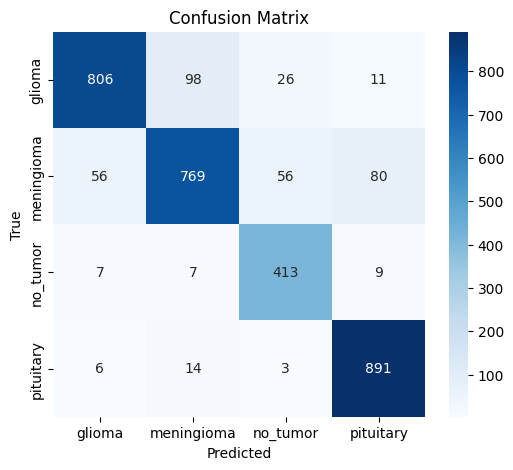

In [9]:
# Load trained individual models
resnet = BaseModel('resnet18').to(DEVICE)
resnet.load_state_dict(torch.load("resnet18_best.pth"))

effnet = BaseModel('efficientnet_b0').to(DEVICE)
effnet.load_state_dict(torch.load("efficientnet_b0_best.pth"))

mobilenet = BaseModel('mobilenet_v3').to(DEVICE)
mobilenet.load_state_dict(torch.load("mobilenet_v3_best.pth"))

# Combine into ensemble
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        with torch.no_grad():
            outputs = [torch.softmax(model(x), dim=1) for model in self.models]
            avg_output = torch.stack(outputs).mean(dim=0)
        return avg_output

ensemble_model = EnsembleModel([resnet, effnet, mobilenet]).to(DEVICE)
ensemble_model.eval()

# Evaluate on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = ensemble_model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Classification report
print("🔍 Ensemble Model Performance on Test Set:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#Single Test
def test_single_image(image_path, class_names, model=ensemble_model):
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    from PIL import Image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        with autocast('cuda'):
            output = model(image_tensor)
        probabilities = output[0]  #First image in batch
        predicted_class = torch.argmax(probabilities).item()

    print("\n🧠 Prediction Results:")
    print(f"👉 Predicted Class: {class_names[predicted_class]}")
    print("\n📊 Class Probabilities:")
    for i, prob in enumerate(probabilities):
        print(f"{class_names[i]}: {prob:.4f}")


In [12]:
test_single_image(r"C:\Users\joane\OneDrive\Desktop\Sem 7\Brain Tummor\Te-pi_0038.jpg", class_names)



🧠 Prediction Results:
👉 Predicted Class: pituitary

📊 Class Probabilities:
glioma: 0.0042
meningioma: 0.0171
no_tumor: 0.0003
pituitary: 0.9784


In [ ]:
#Test multiple images from a folder (e.g. external test set)
def test_multiple_images_from_folder(folder_path, class_names):
 
    resnet = BaseModel('resnet18').to(DEVICE)
    resnet.load_state_dict(torch.load("resnet18_best.pth"))

    effnet = BaseModel('efficientnet_b0').to(DEVICE)
    effnet.load_state_dict(torch.load("efficientnet_b0_best.pth"))

    mobilenet = BaseModel('mobilenet_v3').to(DEVICE)
    mobilenet.load_state_dict(torch.load("mobilenet_v3_best.pth"))

    ensemble_model = EnsembleModel([resnet, effnet, mobilenet]).to(DEVICE)
    ensemble_model.eval()

    # Define only test transforms
    test_transforms = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_dataset = datasets.ImageFolder(folder_path, transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    #Evaluate
    evaluate_model(ensemble_model, test_loader, class_names)


C:\Users\joane\AppData\Local\Temp\ipykernel_21640\814268625.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load("resnet18_best.pth"))
C:\Us

Loaded pretrained weights for efficientnet-b0


C:\Users\joane\AppData\Local\Temp\ipykernel_21640\814268625.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mobilenet.load_state_dict(torch.load("mobilenet_v3_best.pth"


Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.87      0.92       300
  meningioma       0.86      0.87      0.86       306
    no_tumor       0.96      0.97      0.97       405
   pituitary       0.91      0.99      0.95       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



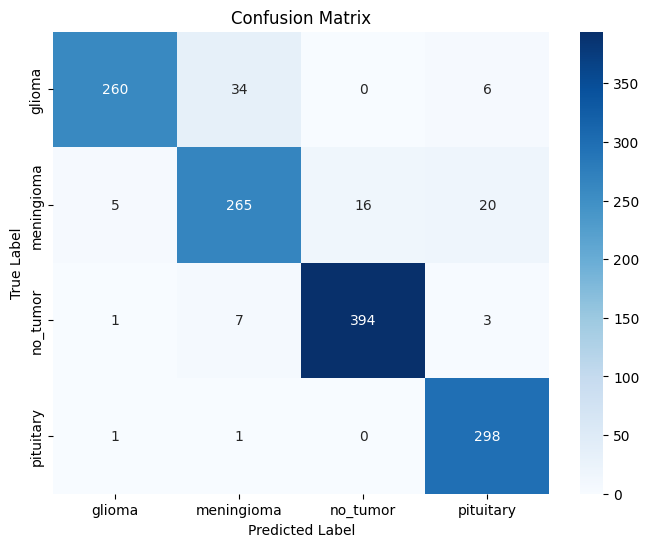

In [17]:
test_multiple_images_from_folder(r"C:\Users\joane\OneDrive\Desktop\Sem 7\Brain Tummor\Testing", class_names)


C:\Users\joane\AppData\Local\Temp\ipykernel_21640\4240563273.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load("resnet18_best.pth"))
C:\U

Loaded pretrained weights for efficientnet-b0

🧠 Brain Tumor Detection System

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.87      0.92       300
  meningioma       0.86      0.87      0.86       306
    no_tumor       0.96      0.97      0.97       405
   pituitary       0.91      0.99      0.95       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



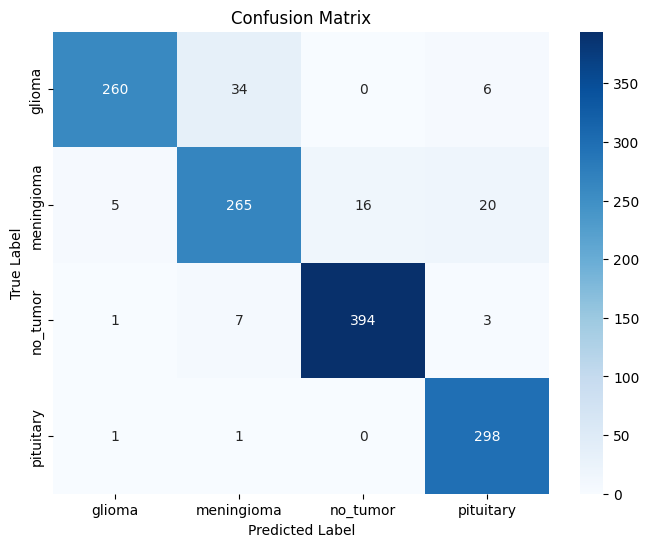

In [ ]:
#Final Execution Block (Unified Single/Batch Inference)
def final_prediction_runner():
    # Load trained ensemble
    resnet = BaseModel('resnet18').to(DEVICE)
    resnet.load_state_dict(torch.load("resnet18_best.pth"))

    effnet = BaseModel('efficientnet_b0').to(DEVICE)
    effnet.load_state_dict(torch.load("efficientnet_b0_best.pth"))

    mobilenet = BaseModel('mobilenet_v3').to(DEVICE)
    mobilenet.load_state_dict(torch.load("mobilenet_v3_best.pth"))

    ensemble_model = EnsembleModel([resnet, effnet, mobilenet]).to(DEVICE)
    ensemble_model.eval()

    print("\n🧠 Brain Tumor Detection System")
    mode = input("Enter 'single' to test one image or 'batch' to test a folder: ").lower()

    if mode == "single":
        image_path = input("📸 Enter the full path of the test image: ").strip()
        test_single_image("resnet18_best.pth", image_path, class_names)

    elif mode == "batch":
        folder_path = input("📂 Enter the path to the test folder (with subfolders as class names): ").strip()

        # Evaluate on batch
        dataset = ImageFolder(folder_path, transform=transforms.Compose([
            transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ]))

        test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
        evaluate_model(ensemble_model, test_loader, class_names)
    else:
        print("⚠️ Invalid input. Please enter 'single' or 'batch'.")

# Run this to start the interface
final_prediction_runner()


C:\Users\joane\AppData\Local\Temp\ipykernel_21640\3151954442.py:25: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\joane\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


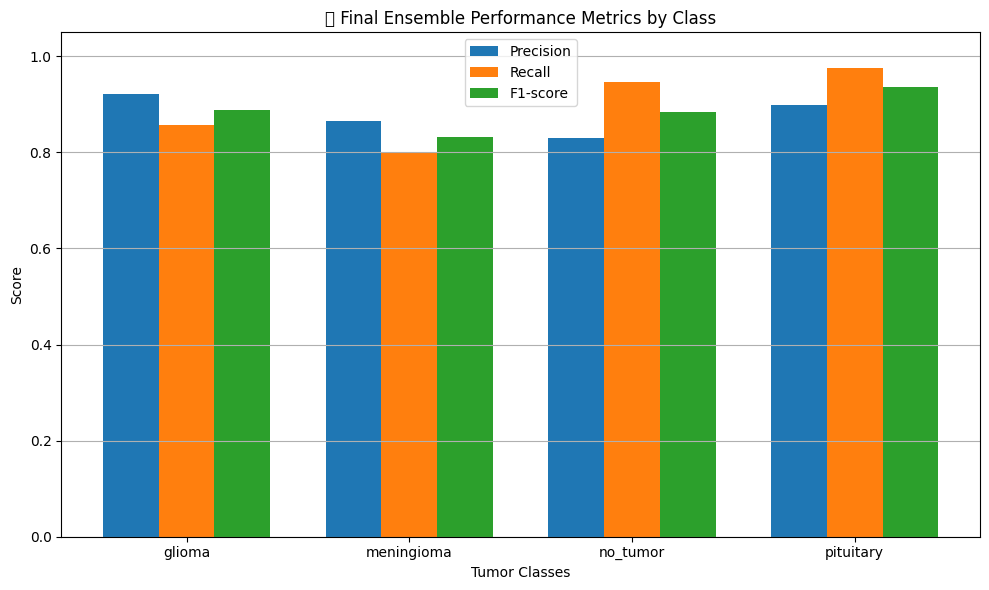


✅ Final Ensemble Model Accuracy: **88.53%**


In [ ]:
#Final Accuracy & Metric Visualization + Summary
def plot_final_accuracy_metrics():
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    classes = list(report.keys())[:-3]  
    f1_scores = [report[cls]['f1-score'] for cls in classes]
    precision_scores = [report[cls]['precision'] for cls in classes]
    recall_scores = [report[cls]['recall'] for cls in classes]

    x = np.arange(len(classes))
    width = 0.25

    plt.figure(figsize=(10, 6))
    plt.bar(x - width, precision_scores, width, label='Precision')
    plt.bar(x, recall_scores, width, label='Recall')
    plt.bar(x + width, f1_scores, width, label='F1-score')

    plt.xlabel('Tumor Classes')
    plt.ylabel('Score')
    plt.title('🔬 Final Ensemble Performance Metrics by Class')
    plt.xticks(x, classes)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    #Print Final Accuracy Summary
    final_accuracy = report['accuracy'] * 100
    print(f"\n✅ Final Ensemble Model Accuracy: **{final_accuracy:.2f}%**")

plot_final_accuracy_metrics()


In [ ]:
resnet_path = r"C:\Users\viraj\Documents\Virajs Projects\BT DETECTION\models\resnet18_best.pth"
efficientnet_path = r"C:\Users\viraj\Documents\Virajs Projects\BT DETECTION\models\efficientnet_b0_best.pth"
mobilenet_path = r"C:\Users\viraj\Documents\Virajs Projects\BT DETECTION\models\mobilenet_v3_best.pth"
